<a href="https://colab.research.google.com/github/chengzwk/UGS-unet-thesis/blob/main/unet_resnet_backbone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
In this notebook we train a U-Net with a Resnet50 backbone with Segmentation Models library. We choose 3 bands from the images.

3-bands combination:
1. RGB

#### Debugging and warnings

In [1]:
# Install ipdb for debugging
!pip install ipdb

import ipdb
%pdb on  # Enable automatic debugger calling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00
Incorrect argument. Use on/1, off/0, or nothing for a toggle.


In [2]:
# Suppress warnings
import logging
logging.getLogger("rasterio").setLevel(logging.ERROR)

#### Install required packages

In [3]:
!pip install pyrsgis
!pip install rasterio
!pip install focal-loss
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00


## Data Preparation

Data preparation can be split into four steps:

1. **Read data**: Import satellite images and corresponding masks, examine their size (128x128 pixels) , and choose the bands want to use.
2. **Normalization**: Normalize image array to the same scale by band.
3. **Mask conversion**: Convert fractional masks into binary masks.
4. **Balance data**: downsampling the images with high proportion of backgrounds.
5. **Visual inspection**: From the prepared dataset, randomly select and plot 8 images and their corresponding binary mask for visual inpsection.


Our mask files are annotated as 5 classes:
*   12: Impervious surfaces and buildings (class number 2)
*   3: Low vegetation (class number 3, and so on)
*   4: Trees
*   5: Water
*   6: Clutter/Background

When computing proportion of background and urban green space,classes 3 and 4 are counted as urban green space, while other classes are counted as background.

Note that in the case of two classes having the same fractions, this script will convert the binary mask to the first one.

In [4]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Import packages
import os
import rasterio
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from osgeo import gdal

In [7]:
def normalize_by_layer(image_array):
    """
    Function to normalize image data to the same max(1) and min(0)
    Since different layers(bands) have different scales, normalization will be done layer by layer
    """
    # Normalize by band
    image_array = image_array.astype(np.float32)  # Convert dtype of image file from int to float

    for i in range(image_array.shape[2]):
        layer_min = np.min(image_array[:, :, i])
        layer_max = np.max(image_array[:, :, i])

        try:
            image_array[:, :, i] = (image_array[:, :, i] - layer_min) / (layer_max - layer_min)
        except ZeroDivisionError:
            print(f"Band {i} has zero variation (min = max = {layer_min}). Skipping normalization.")
            image_array[:, :, i] = 0  # Set the band to default value 0

    return image_array

In [8]:
def read_file(image_dir, mask_dir):
    """
    Read satellite image files and corresponding masks as numpy arrays,
    normalize image array to the same scale by band, and convert fractional masks into binary masks.
    """
    image_dataset = []
    mask_dataset = []

    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]  # Get list of image file names

    for image_filename in image_files:
        mask_filename = image_filename[:-4] + '_fractional_mask.tif'  # Generate corresponding mask file name
        image_path = os.path.join(image_dir, image_filename)
        mask_path = os.path.join(mask_dir, mask_filename)

        # Read image file
        image = gdal.Open(image_path)
        image_array = image.ReadAsArray()
        image_array = np.transpose(image_array, [1, 2, 0])  # move the axis for bands to the third axis

        # Check image dimension:
        if image_array.shape[:2] != (128, 128):
            print(f"⚠️ Warning: {image_filename} has incorrect dimensions {image_array.shape[:2]}, skipping...")
            continue  # Skip this image and its mask and move to the next one

        image_array[np.isnan(image_array)] = 0              # replace nan with 0
        image_array = image_array[:, :, (1, 2, 3)]          # get the bands you want; (1, 2, 3) is RGB bands
        image_array = normalize_by_layer(image_array)       # Normalize the image by band

        # Read mask file
        mask = gdal.Open(mask_path)
        mask_array = mask.ReadAsArray()
        mask_array = np.transpose(mask_array, [1, 2, 0])    # move the axis for bands to the third axis

        # Check mask dimension:
        if mask_array.shape[:2] != (128, 128):
            print(f"⚠️ Warning: {mask_filename} has incorrect dimensions {mask_array.shape[:2]}, skipping...")
            continue  # Skip this image its mask and move to the next one

        mask_array[np.isnan(mask_array)] = 0                           # replace nan with 0
        classes = np.arange(2, 7)                                      # class numbers: 2, 3, 4, 5, 6
        mask_array = np.argmax(mask_array, axis=2, keepdims=True) + 2  # Convert fractional mask to binary mask

        image_dataset.append(image_array)
        mask_dataset.append(mask_array)

    image_dataset = np.array(image_dataset)
    mask_dataset = np.array(mask_dataset)

    return image_dataset, mask_dataset


In [9]:
def remove_images(image_dataset, mask_dataset, threshold):
    """
    This function remove images and corresponding masks with high proportion of backgrounds
    Definition of backgrounds:
        - urban green space: classes 3 and 4
        - backgrounds: classes 2, 5, and 6
    Input:
        - image_dataset, mask_dataset: numpy array of satellite images and corresponding masks
        - threshold: if proportion of backgrounds is higher than threshold in the image, the image will be removed
    Output:
        - balanced array without those chips
    """
    # Get the id of images to remove
    id_to_remove = []

    for i in range(len(mask_dataset)):
        mask = mask_dataset[i, :, :, 0]
        tot_pixel = mask.size
        background_pixel = np.count_nonzero(np.isin(mask, [2, 5, 6]))
        if background_pixel > tot_pixel * threshold:
            id_to_remove.append(i)

    # Get the balanced dataset
    image_dataset_balanced = []
    mask_dataset_balanced = []

    for i in range(len(image_dataset)):
        if not(i in id_to_remove):
            image = image_dataset[i]
            mask = mask_dataset[i]
            image_dataset_balanced.append(image)
            mask_dataset_balanced.append(mask)

    image_dataset_balanced = np.array(image_dataset_balanced)
    mask_dataset_balanced = np.array(mask_dataset_balanced)

    return image_dataset_balanced, mask_dataset_balanced

In [38]:
def inspect_dataset(image_dataset, mask_dataset, sample_size):
    """
    # Randomly select and plot sample_size images and corresponding binary masks for visual inspection
    """
    # Randomly select sample_size files
    samples = random.sample(list(np.arange(len(image_dataset))), min(sample_size, len(image_dataset)))

    sample_images = [image_dataset[i, :, :, :] for i in samples]
    sample_masks = [mask_dataset[i, :, :, :] for i in samples]

    # Define class labels
    #class_labels = {
    #    2: "Class 1 and 2: impervious",
    #    3: "Class 3: low veg",
    #    4: "Class 4: trees",
    #    5: "Class 5: water",
    #    6: "Class 6: clutter"}

    # Define class colors
    class_colors = {
        2: "#808080",  # Gray
        3: "#ADFF2F",  # Light Green
        4: "#006400",  # Dark Green
        5: "#1E90FF",  # Blue
        6: "#8B4513",  # Brown
    }

    # Display the randomly selected images and masks
    for i in range(len(sample_images)):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create figure and subplots

        # Plot the satellite image
        axes[0].imshow(sample_images[i][:, :, :3])
        axes[0].set_title("Satellite Image")
        # axes[0].axis("off")

        # Plot the mask with color mapping
        cmap = plt.cm.colors.ListedColormap([class_colors[c] for c in sorted(class_colors)])
        axes[1].imshow(sample_masks[i][:, :, 0], cmap=cmap)
        axes[1].set_title("Mask")
        # axes[1].axis("off")

        # Create a legend and place it outside the plots
        legend_patches = [mpatches.Patch(color=color, label=f"Class {cls}") for cls, color in class_colors.items()]
        fig.legend(handles=legend_patches, loc="center left", bbox_to_anchor=(1.02, 0.5), title="Legend")

        # Adjust layout to make space for the legend
        # plt.tight_layout(rect=[0, 0, 0.85, 1])  # Shrink plot area to fit the legend
        plt.subplots_adjust(right=0.95)


(63, 128, 128, 3) (63, 128, 128, 1)


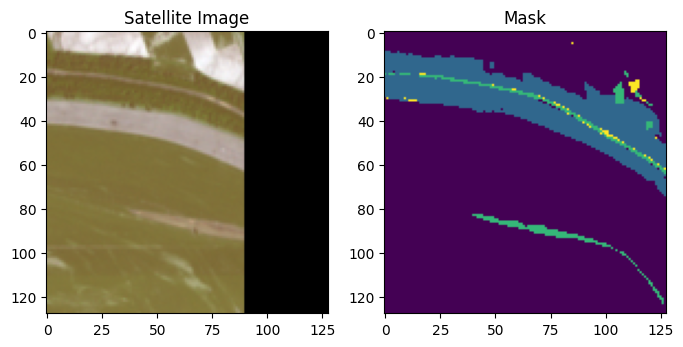

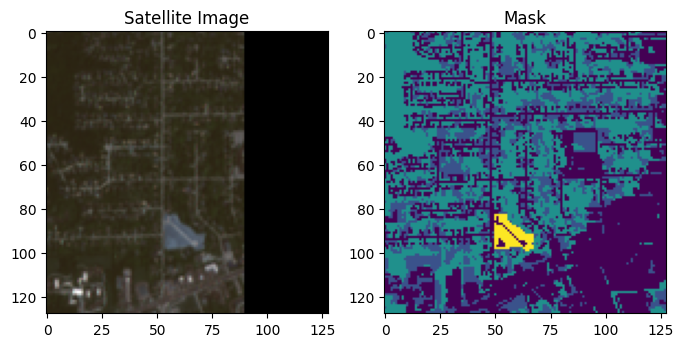

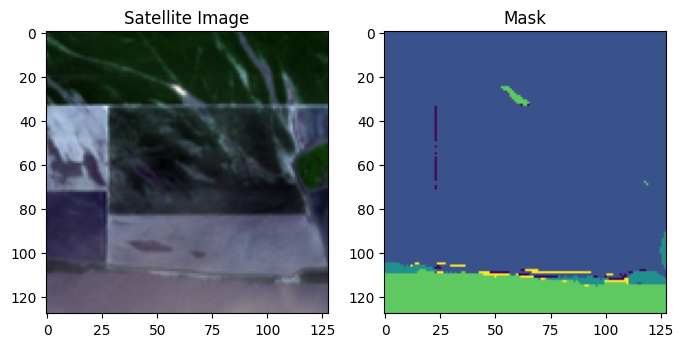

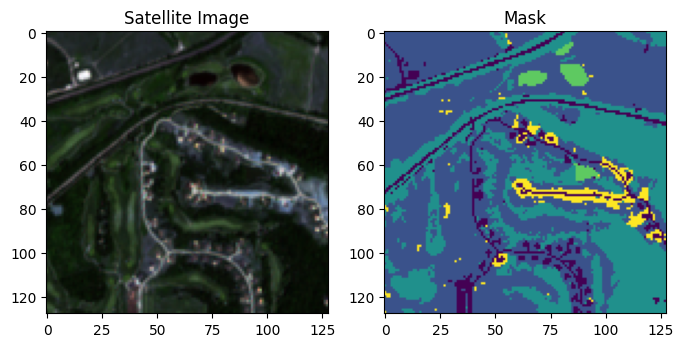

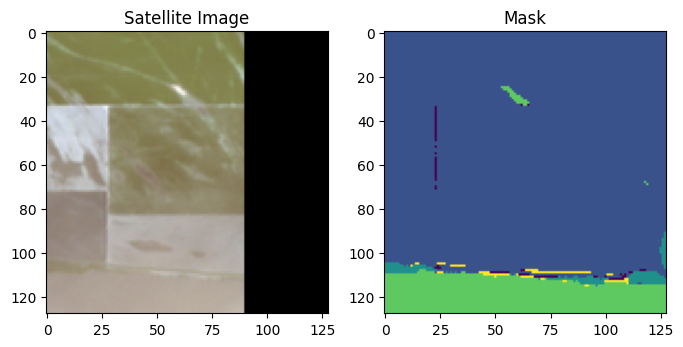

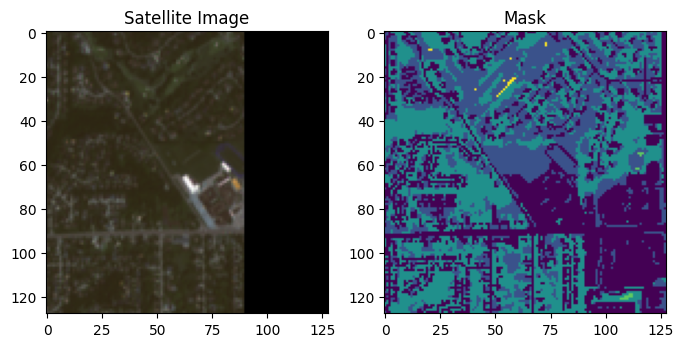

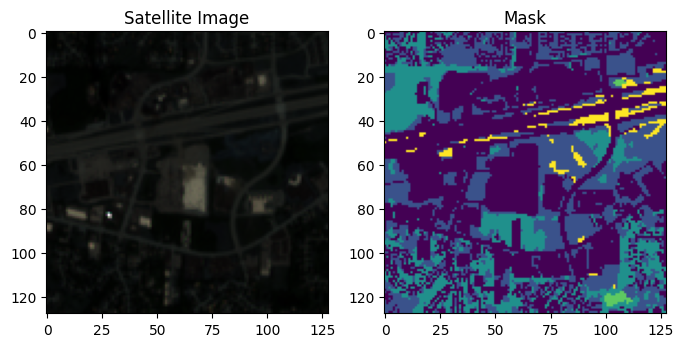

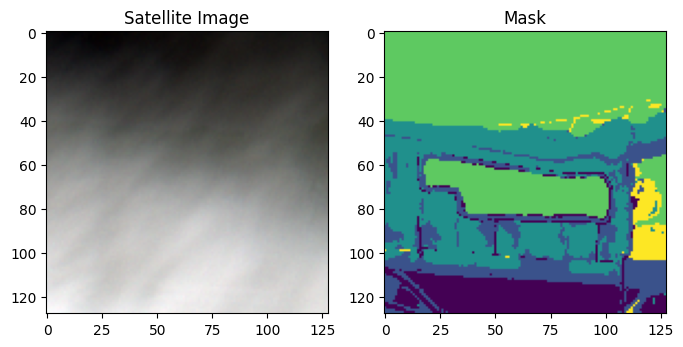

In [13]:
# Set dataset directories
image_directory = "/content/drive/MyDrive/Omdena/urban-green-frankfurt/example_dataset_images_cropped"
mask_directory = "/content/drive/MyDrive/Omdena/urban-green-frankfurt/example_dataset_masks_cropped"

# batch_size = 8

# Read image files
image_dataset, mask_dataset = read_file(image_directory, mask_directory)

# Get the balanced dataset
#image_dataset_balanced, mask_dataset_balanced = remove_images(image_dataset, mask_dataset, 0.86)
#del image_dataset, mask_dataset
#print(image_dataset_balanced.shape, mask_dataset_balanced.shape)

In [43]:
# Print satistics of the dataset
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Min pixel value in image is: ", image_dataset.min())
print("Labels in the mask are : ", np.unique(mask_dataset))

total_pixels = mask_dataset.size  # Get total number of pixels in the dataset

for i in range(2, 7):
    count = np.count_nonzero(mask_dataset == i)
    percentage = (count / total_pixels) * 100
    print(f"Number of cells with value {i}: {count} ({percentage:.2f}%)")

background_count = np.count_nonzero(np.isin(mask_dataset, [2, 5, 6]))
background_percentage = (background_count / total_pixels) * 100
print(f"Number of background pixels: {background_count} ({background_percentage:.2f}%)")

low_veg_count = np.count_nonzero(mask_dataset == 3)
low_veg_percentage = (low_veg_count / total_pixels) * 100
print(f"Number of low vegetation pixels: {low_veg_count} ({low_veg_percentage:.2f}%)")

tree_count = np.count_nonzero(mask_dataset == 4)
tree_percentage = (tree_count / total_pixels) * 100
print(f"Number of tree pixels: {tree_count} ({tree_percentage:.2f}%)")


Image data shape is:  (63, 128, 128, 3)
Mask data shape is:  (63, 128, 128, 1)
Max pixel value in image is:  1.0
Min pixel value in image is:  0.0
Labels in the mask are :  [2 3 4 5 6]
Number of cells with value 2: 202572 (19.63%)
Number of cells with value 3: 316587 (30.67%)
Number of cells with value 4: 461769 (44.74%)
Number of cells with value 5: 40887 (3.96%)
Number of cells with value 6: 10377 (1.01%)
Number of background pixels: 253836 (24.59%)
Number of low vegetation pixels: 316587 (30.67%)
Number of tree pixels: 461769 (44.74%)


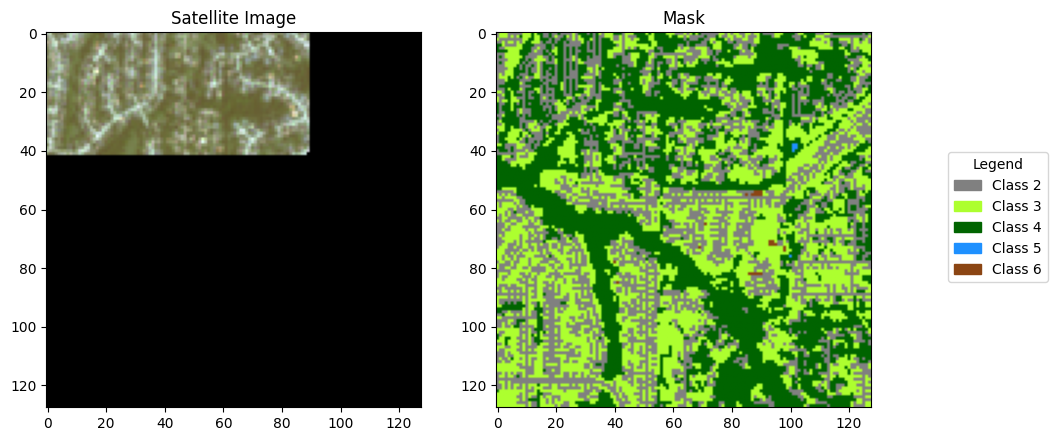

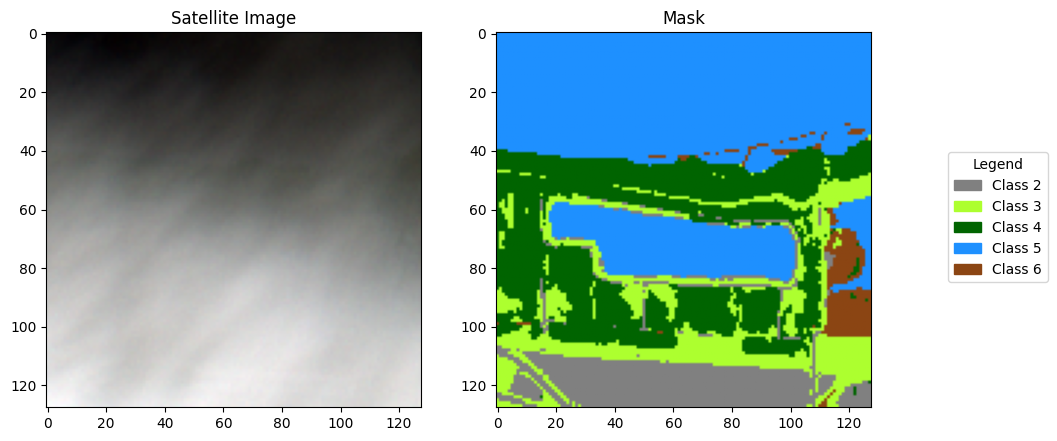

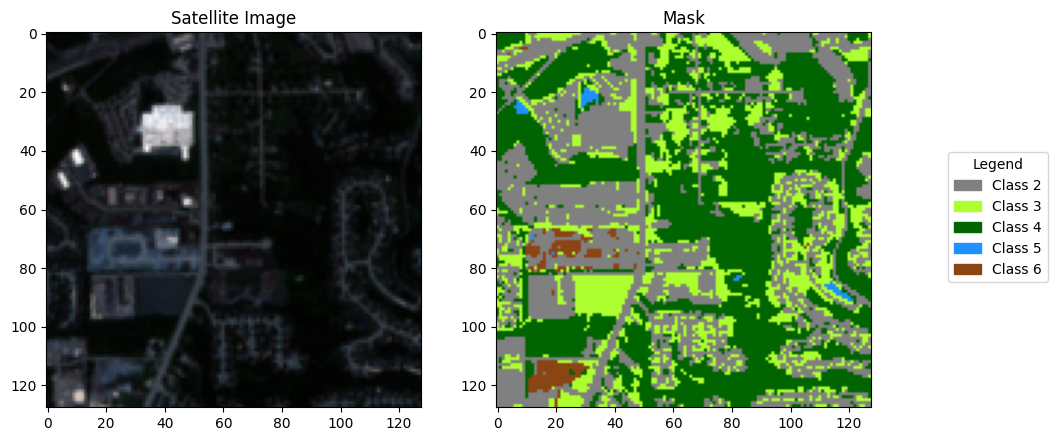

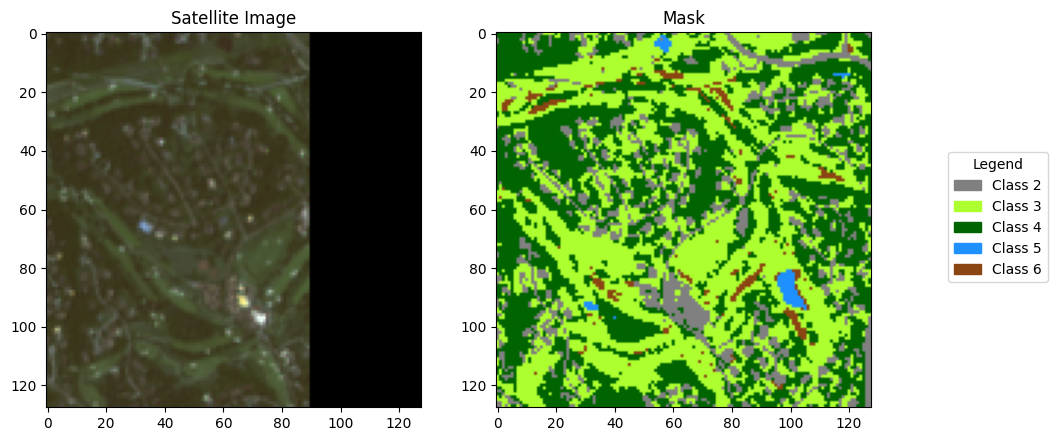

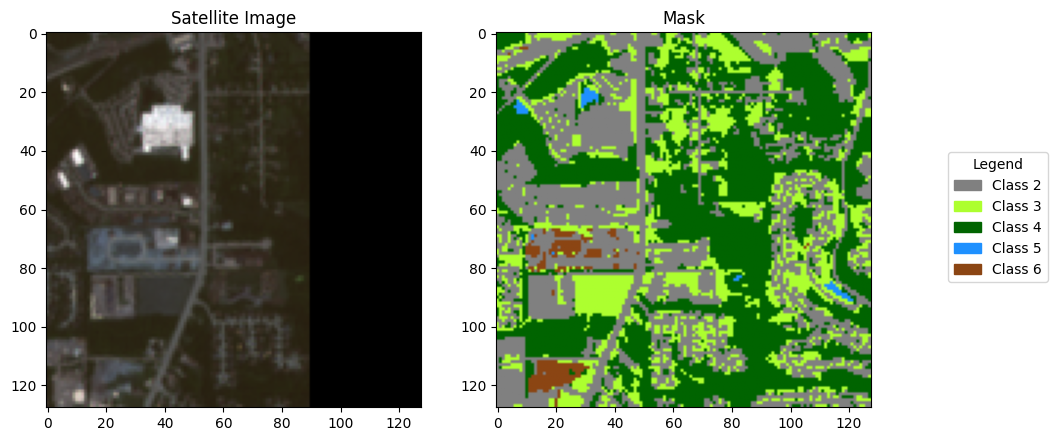

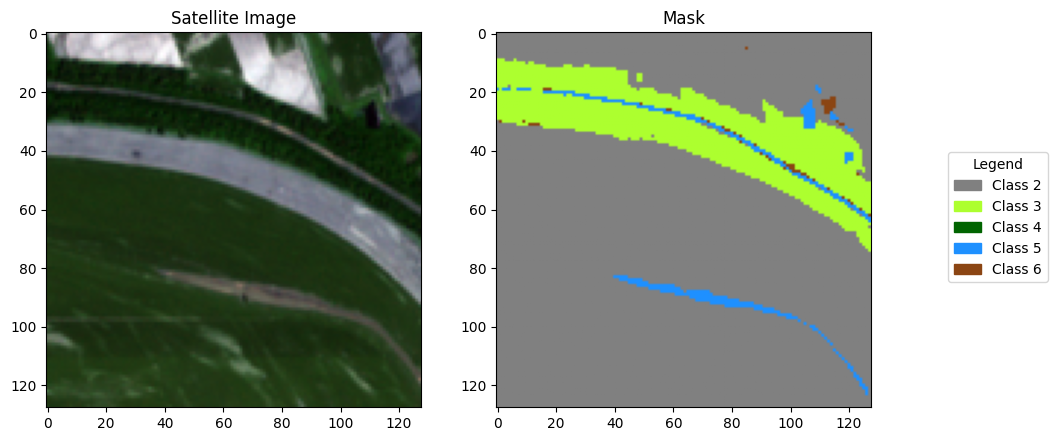

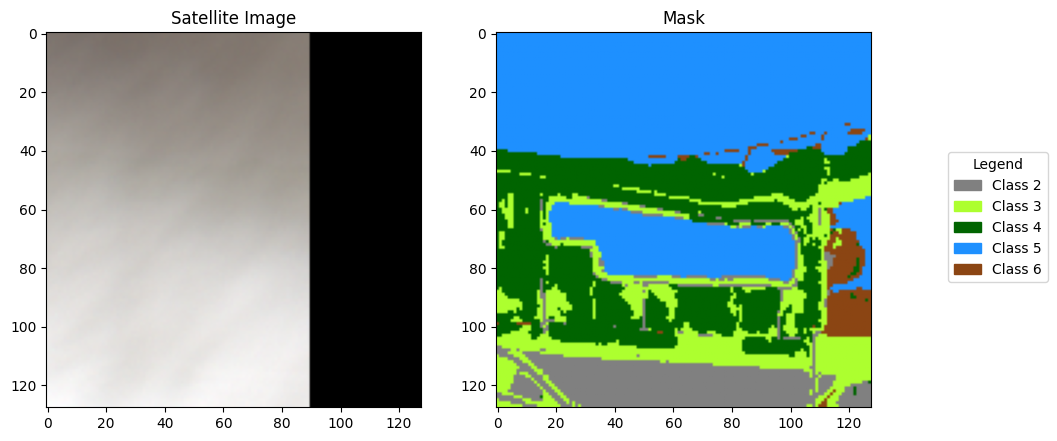

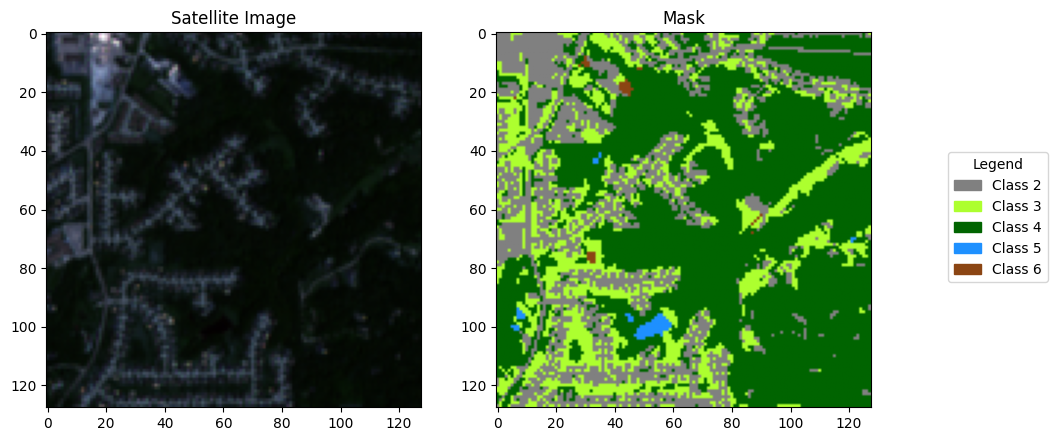

In [40]:
# Visually inspect 8 images and corresponding masks
inspect_dataset(image_dataset, mask_dataset, 8)

## Build training and test set

#### Split and preprocess to fit model architecture

In [44]:
# Train-validation-test split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(image_dataset, mask_dataset, test_size = 0.15, random_state = 42)

del image_dataset, mask_dataset
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(53, 128, 128, 3) (10, 128, 128, 3)
(53, 128, 128, 1) (10, 128, 128, 1)


In [47]:
# preprocess input to fit model architecture
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import keras
import tensorflow
from keras.layers import Input, Conv2D
from keras.models import Model

BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)  # get the preprocessing function

X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
print(X_train.shape, X_val.shape)

env: SM_FRAMEWORK=tf.keras
(53, 128, 128, 3) (10, 128, 128, 3)


In [49]:
# turn mask_dataset into categorical (one-hot encoding to fit the model architecture)
from tensorflow.keras.utils import to_categorical

# Adjust class values
y_train_adjusted = y_train - 2  # Shift class values from 2-6 to 0-4
y_val_adjusted = y_val - 2

# y_train
train_masks_cat = to_categorical(y_train_adjusted, num_classes=5)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], -1))

# y_val
val_masks_cat = to_categorical(y_val_adjusted, num_classes=5)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], -1))

print(y_train_cat.shape, y_val_cat.shape)


(53, 128, 128, 5) (10, 128, 128, 5)


## Modeling training

#### Model building and training